In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, cross_val_score
from sklearn.feature_selection import RFECV

CRITICAL_TEMP = 'critical_temp'

In [3]:
# Setup matplotlib

sns.set()

In [20]:
# Define functions

def print_metrics(y, y_hat):
    rmse = mean_squared_error(y, y_hat, squared=False)
    r2 = r2_score(y, y_hat)
    print(f'RMSE: {rmse:.4f}\nR^2: {r2:.4f}')

def print_cross_validate_scores(scores):
    for scoring, score in scores.items():
        if not scoring.startswith("test_"):
            continue
        
        scoring = scoring[len("test_"):]
        
        # don't display negative scores
        if scoring.startswith("neg"):
            scoring = scoring[len("neg_"):]
            score = -score
        
        # show root mean squared error instead of mean squared error
        if scoring == "mean_squared_error":
            scoring = "RMSE"
            score = np.sqrt(score)

        print(f'{scoring}: {score.mean():.2f} (+/- {(score.std() * 2):.2f})')

def plot_predictions(estimator, X, y, filename):
    predicted = cross_val_predict(estimator, X, y)
    
    fig, ax = plt.subplots()
    ax.scatter(y, predicted, s=2)
#     ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    plt.savefig(filename)
    plt.show()

def run_linear_regression(*args, **kwargs):
    return run_regression(*args, **kwargs, regression=LinearRegression())
    
def run_regression(X, y, filename, regression, should_print_metrics=True, plot=False):
    scores = cross_validate(regression, X, y, 
                            scoring=['neg_mean_squared_error', 'r2', 'neg_median_absolute_error'],
                           return_estimator=True)

    if should_print_metrics:
        print_cross_validate_scores(scores)
        
    if plot:
        plot_predictions(regression, X, y, filename)
    
    return scores['estimator']

def recursive_feature_elim(estimator, X, y, plot=False):
    linreg = LinearRegression()
    rfecv = RFECV(estimator=linreg, scoring="neg_mean_squared_error")
    rfecv.fit(X, y)

    print(f'Optimal number of features: {rfecv.n_features_}')

    if plot:
        # Plot number of features VS. cross-validation scores
        plt.figure()
        plt.xlabel("Number of features selected")
        plt.ylabel("Negative mean squared error")
        plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
        plt.show()
    
    # Inspect dropped features from RFE
    dropped_features = []
    for i, isSelected in enumerate(rfecv.support_):
        if not isSelected:
            dropped_features.append(list(X)[i])
    
    print(f'Dropped features: {", ".join(dropped_features)}')
    
    return rfecv, dropped_features

def iterative_feature_addition(scoring, num_folds, regression, print_progress=False, plot=True):
    # num_folds: increase for greater precision but worse runtime
    
    # At each step, test adding each element feature. Stick with the best one from each step, according to `scoring`
    # Keep track of the best set of features of any length, and return it
    
    X_grow = X.copy()
    all_time_best_score = -float('inf')  # beaten by whatever the first score is
    results = []

    while len(list(X_grow)) < len(list(X_incl_elements)):
        best_score = -float('inf')

        for element in list(all_elements_X):
            if element in list(X_grow):
                continue

            X_tmp = X_grow.copy()
            X_tmp[element] = X_elements[element].to_numpy()

            score = cross_val_score(regression, X_tmp, y, cv=num_folds, scoring=scoring).mean()
            if score > best_score:
                best_X = X_tmp
                best_score = score

        X_grow = best_X

        # optionally print progress because this is long running
        if print_progress:
            print(f'best score with {len(list(X_grow))} features: {best_score}')
        
        # store results for plotting or further analysis
        results.append({
            'num_features': len(list(X_grow)),
            'added_feature': list(best_X)[-1],
            'best_score': best_score
        })

        if best_score > all_time_best_score:
            all_time_best_X = best_X
            all_time_best_score = best_score
    
    if plot:
        plot_iterative_feature_addition_results(results)
    
    return all_time_best_X, all_time_best_score, results

def plot_iterative_feature_addition_results(results):
    x_points = [r['num_features'] for r in results]
    y_points = [r['best_score'] for r in results]
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel(f"Score")
    plt.plot(x_points, y_points)
    plt.show()

def get_poly_no_interaction(X, degree):
    # sklearn's PolynomialFeatures usefully adds polynomial terms, but also adds interacting terms (product of each feature)
    # we don't want the interacting terms, as this increases the amount of correlation between features
    
    poly = PolynomialFeatures(degree=degree)
    X_poly_interaction = poly.fit_transform(X).T
    X_poly_no_interaction = []

    names = poly.get_feature_names()
    for i in range(len(names)):
        if " " not in names[i]:
            X_poly_no_interaction.append(X_poly_interaction[i])
    
    return np.array(X_poly_no_interaction).T

In [23]:
# Load data and perform train-test splitting before doing any analysis

data_df = pd.read_csv('train.csv')
elements_df = pd.read_csv('unique_m.csv')

# check that the two tables' entries are in the same order
assert(elements_df[CRITICAL_TEMP].equals(data_df[CRITICAL_TEMP]))

# need to combine the two datasets before performing train-test split to make sure the right rows are in each split
all_data_X = data_df.loc[:, :'wtd_std_Valence']
all_elements_X = elements_df.loc[:, :'Rn']
all_X = pd.concat([all_data_X, all_elements_X], axis=1)

all_y = data_df[CRITICAL_TEMP]

# test size 0.33 to match paper for comparability
# random_state set to some constant int so that the results are reproduceable
# and so that rerunning the script does not constitute peeking at the test data
X_incl_elements, X_incl_elements_test, y, y_test = train_test_split(all_X, all_y, test_size=0.33, random_state=42)

# now create input matrices without the element data
X = X_incl_elements.loc[:, list(all_data_X)]
X_test = X_incl_elements_test.loc[:, list(all_data_X)]

X_elements = X_incl_elements.loc[:, list(all_elements_X)]
X_elements_test = X_incl_elements_test.loc[:, list(all_elements_X)]

In [6]:
# Calculate mean correlation between each feature and the critical temperature
aggregations = "mean wtd gmean entropy range std".split()

X_and_y = X.copy()
X_and_y.loc[:, CRITICAL_TEMP] = y

mean_corr = X.apply(lambda x: x.corr(y)).abs().mean()
elements_mean_corr = X_elements.apply(lambda x: x.corr(y)).abs().mean()
print(f'Mean correlation between general inputs and critical temp is {mean_corr}')
print(f'Mean correlation between elements inputs and critical temp is {elements_mean_corr}')

Mean correlation between general inputs and critical temp is 0.3861139674822093
Mean correlation between elements inputs and critical temp is 0.07750819189168956


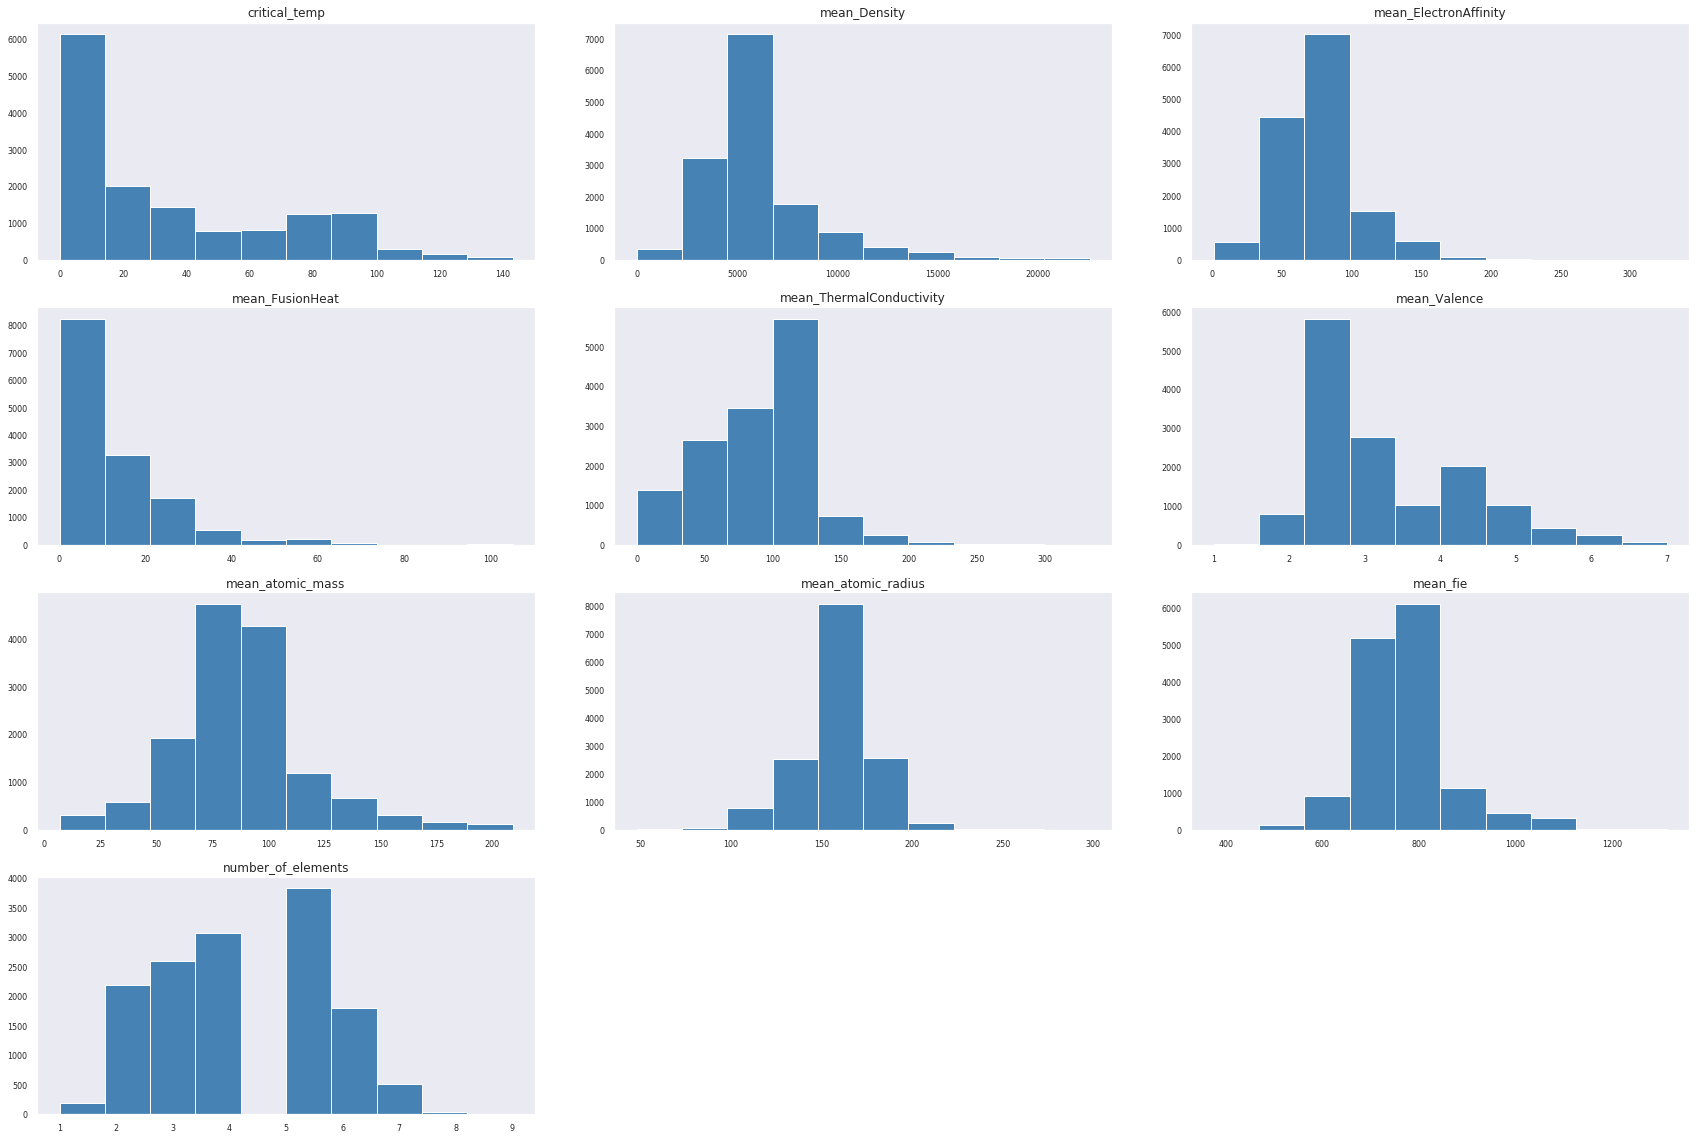

In [6]:
# Do some visualisation of the data to analyse the features

# First, univariate visualisation of the means

def get_categories(supercategory):
    return [cat for cat in list(X) if supercategory in cat and not any([a in cat for a in aggregations if a != supercategory])]

raw_categories = [CRITICAL_TEMP, "number_of_elements"] + get_categories("mean")

X_and_y.loc[:, raw_categories].hist(bins=10, color='steelblue', linewidth=1.0,
              xlabelsize=8, ylabelsize=8, grid=False)
plt.tight_layout(rect=(0, 0, 4, 4))

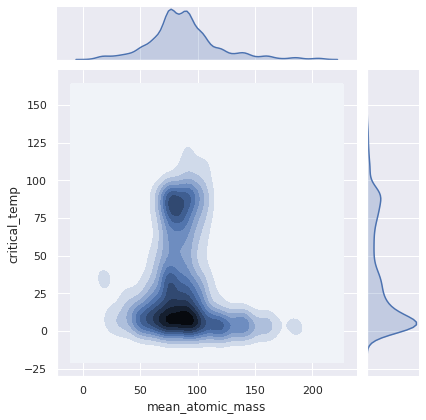

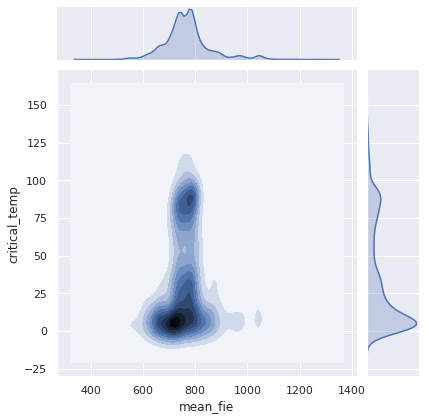

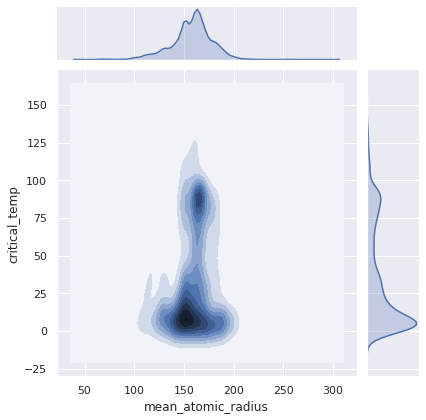

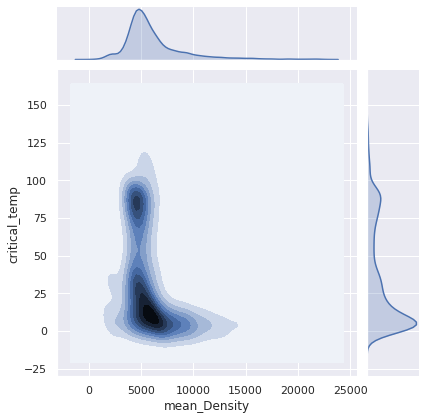

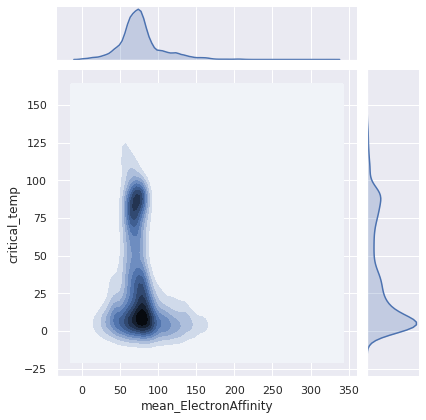

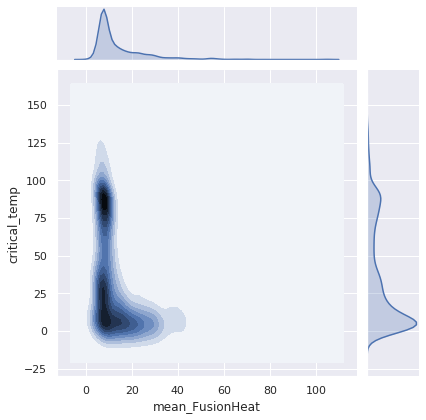

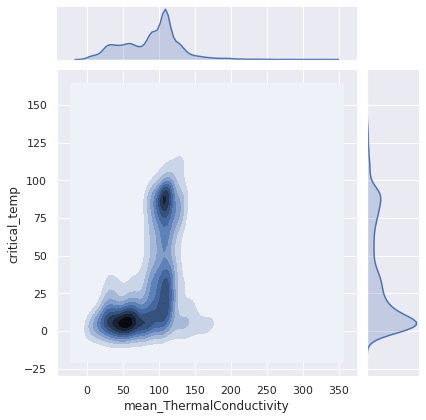

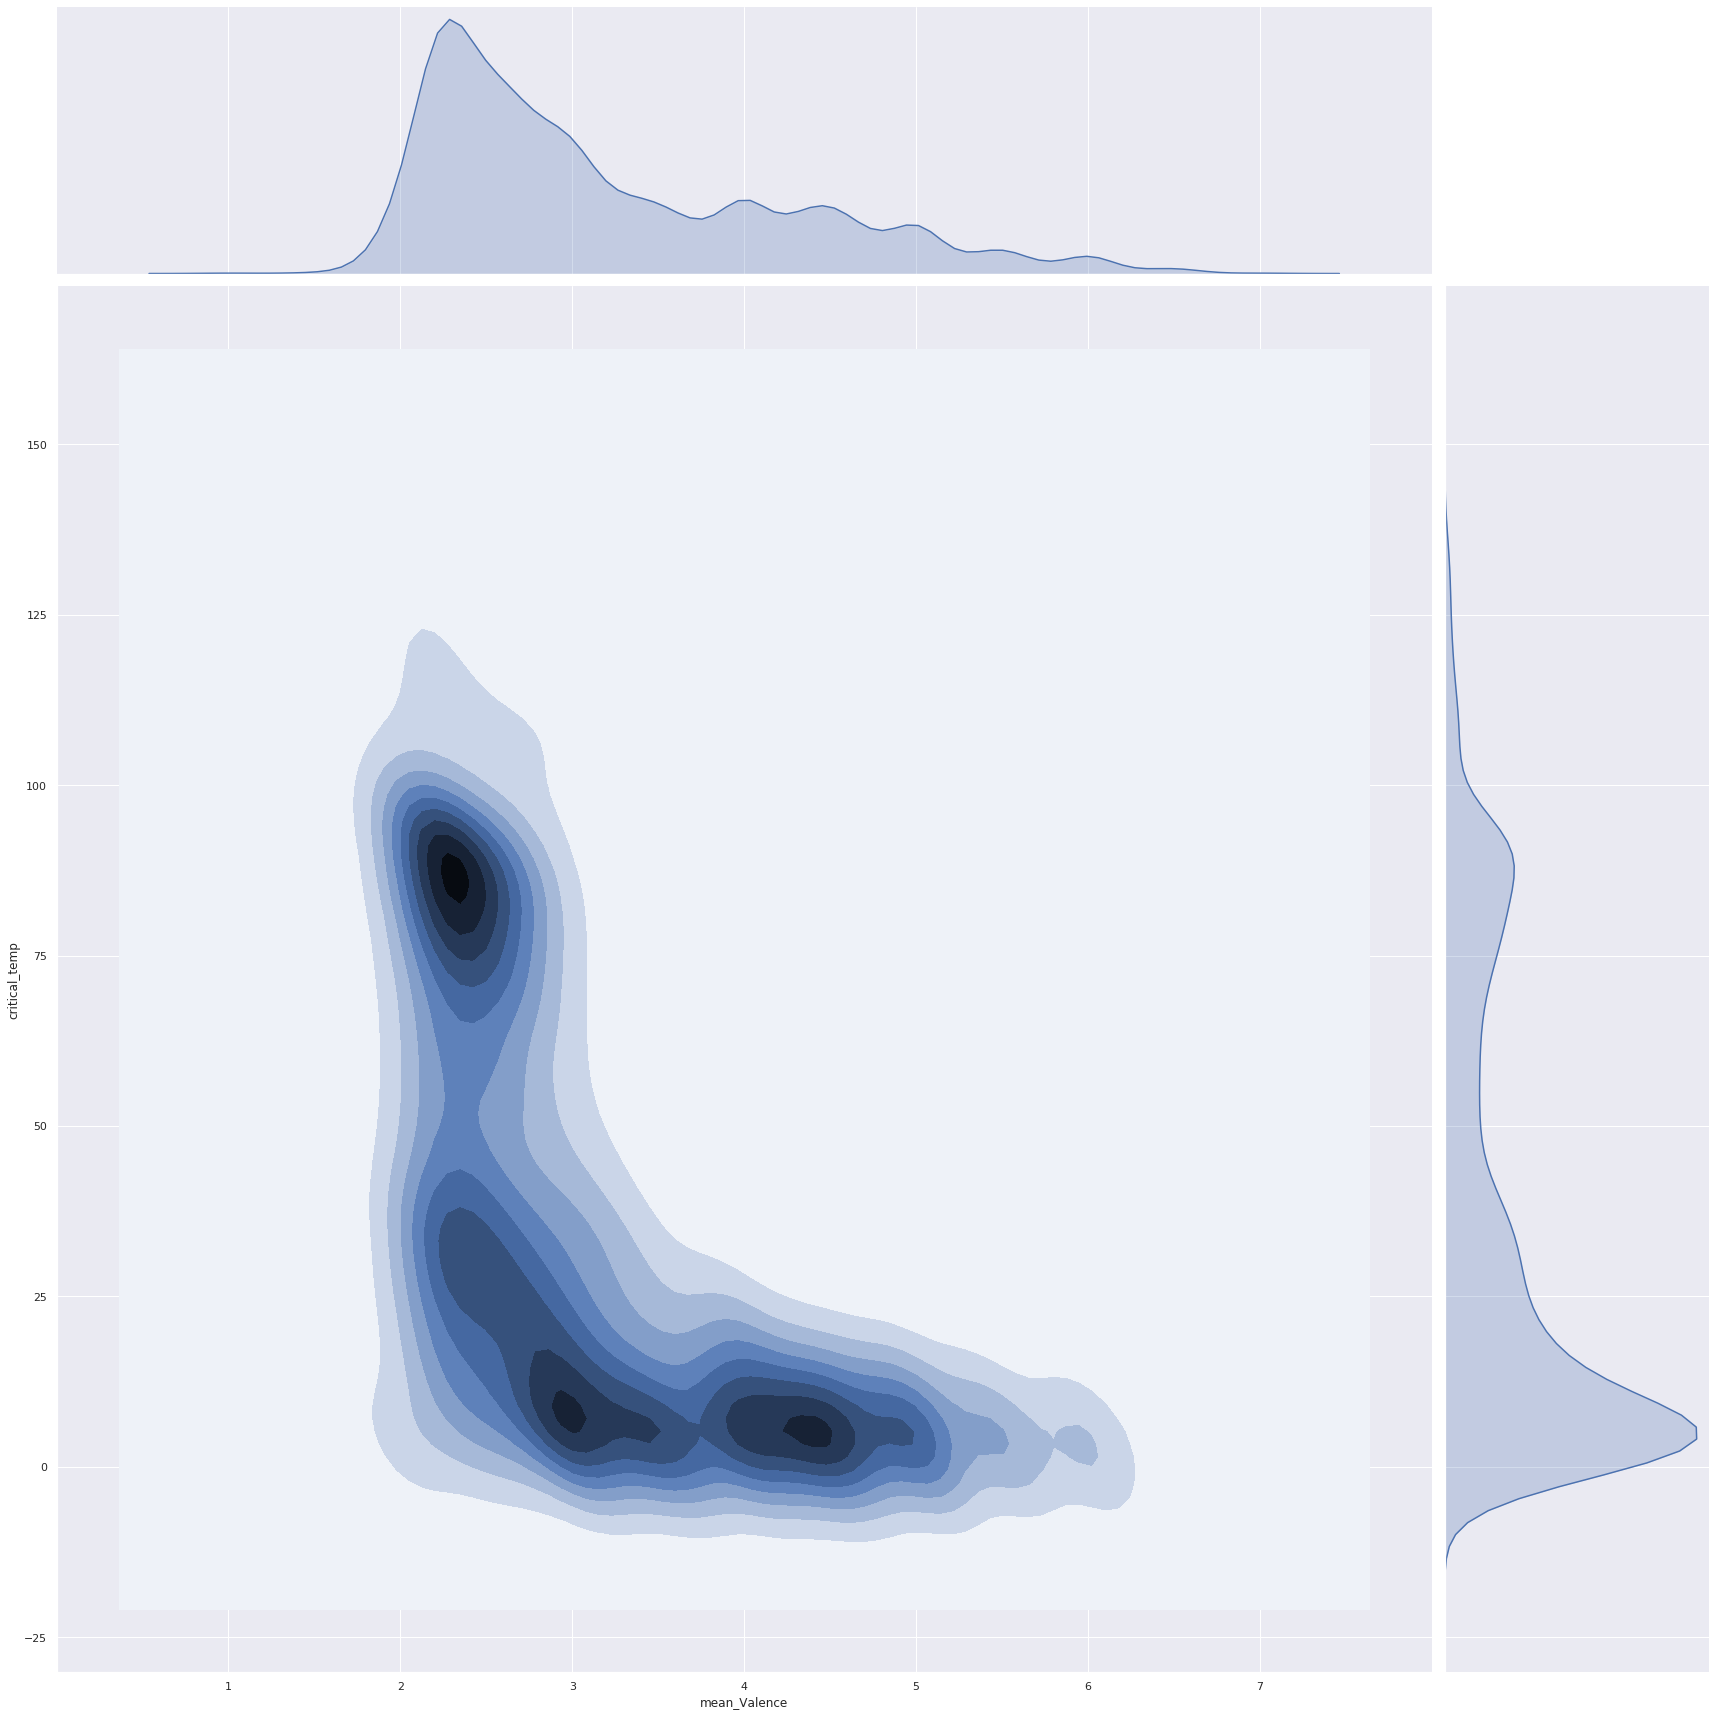

In [7]:
# Visualise relation between each of our standard categories, with line of best fit

raw_minus_crit = raw_categories.copy()
raw_minus_crit.remove(CRITICAL_TEMP)
raw_minus_crit.remove("number_of_elements")
for feature in raw_minus_crit:
    sns.jointplot(feature, CRITICAL_TEMP, data=X_and_y, kind="kde")

plt.tight_layout(rect=(0, 0, 4, 4))

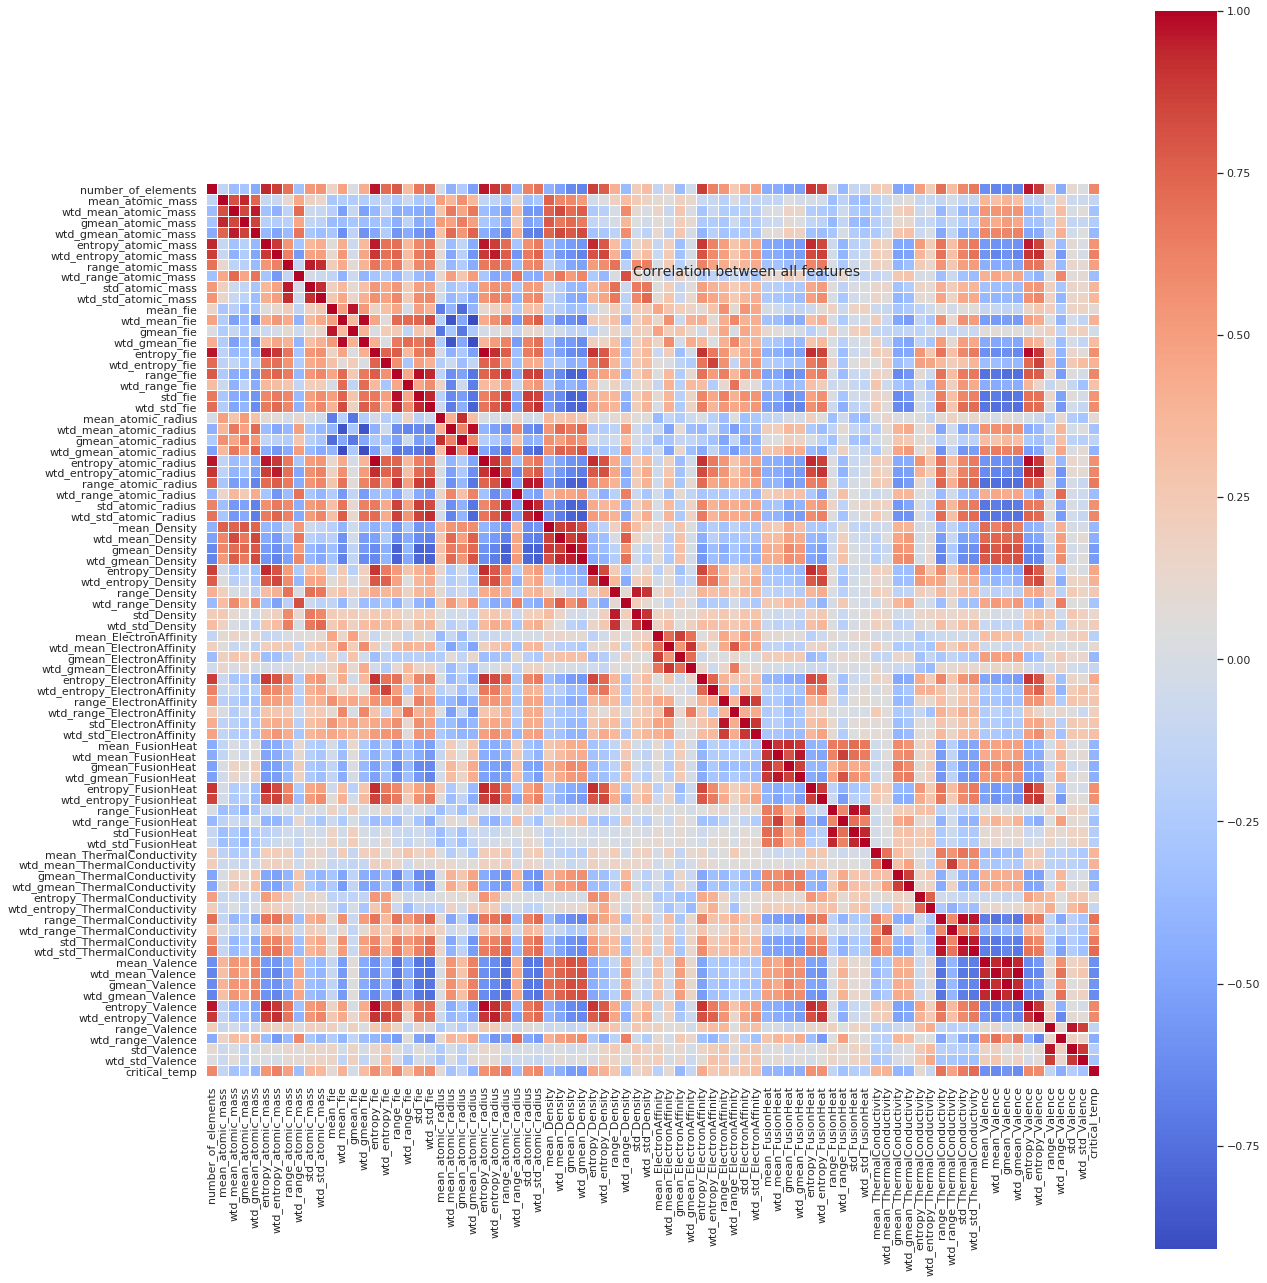

In [8]:
# Visualise correlation between all features in a heatmap

f, ax = plt.subplots(figsize=(20, 16))
corr = X_and_y.corr()
heatmap = sns.heatmap(round(corr,2), ax=ax, cmap="coolwarm", square=True, xticklabels=True, yticklabels=True, linewidth=0.02)
f.subplots_adjust(top=1.2)
f.suptitle('Correlation between all features', fontsize=14);

RMSE: 17.61 (+/- 0.40)
r2: 0.74 (+/- 0.02)
median_absolute_error: 10.19 (+/- 0.29)


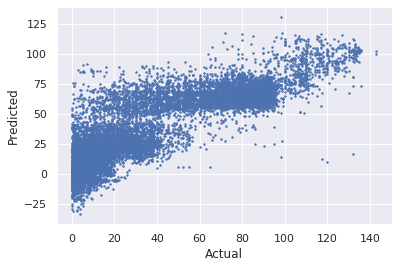

<Figure size 432x288 with 0 Axes>

In [9]:
# Basic linear regression
reg = run_linear_regression(X, y, "basic_regression", plot=True)

RMSE: 17.61 (+/- 0.40)
r2: 0.74 (+/- 0.02)
median_absolute_error: 10.19 (+/- 0.29)


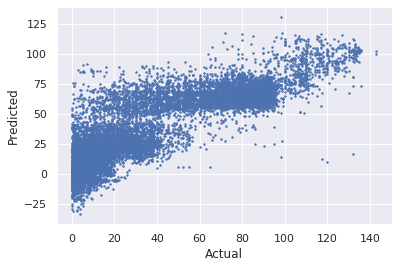

<Figure size 432x288 with 0 Axes>

In [10]:
# Try standardising the input
X_scaled = preprocessing.scale(X)
run_linear_regression(X_scaled, y, "standardised_regression", plot=True);

Optimal number of features: 79


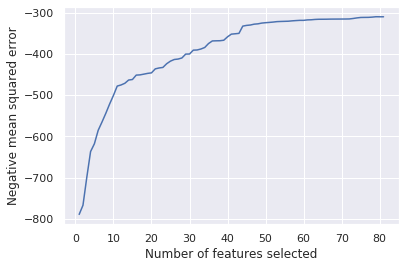

Dropped features: wtd_mean_Density, wtd_range_Density
RMSE: 17.61 (+/- 0.40)
r2: 0.74 (+/- 0.02)
median_absolute_error: 10.17 (+/- 0.29)


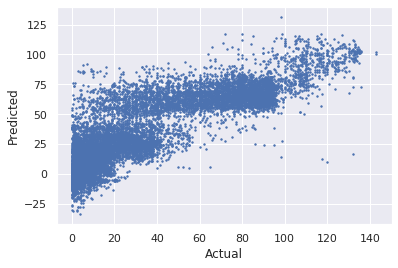

RMSE: 17.61 (+/- 0.40)
r2: 0.74 (+/- 0.02)
median_absolute_error: 10.19 (+/- 0.29)
Mean coefficient for wtd_mean_Density: 0.0003478078575736454
Mean coefficient for wtd_range_Density: -0.0002034347263778713


<Figure size 432x288 with 0 Axes>

In [11]:
# Perform recursive feature elimination

rfecv, dropped_features = recursive_feature_elim(LinearRegression(), X, y, plot=True)

# Run linear regression without the eliminated features, showing that model performance is not reduced
X_reduced = X.drop(dropped_features, axis=1)
run_linear_regression(X_reduced, y, "RFE dropped features", plot=True)

# And let's inspect the coefficients of the dropped features in a linear regression on all basic features
models = run_linear_regression(X, y, "basic_regression")
for dropped_feature in dropped_features:
    index = list(X).index(dropped_feature)
    coeffs = [model.coef_[index] for model in models]
    
    print(f'Mean coefficient for {dropped_feature}: {sum(coeffs) / float(len(coeffs))}')

RMSE: 25.78 (+/- 24.59)
r2: 0.31 (+/- 1.32)
median_absolute_error: 9.32 (+/- 0.25)


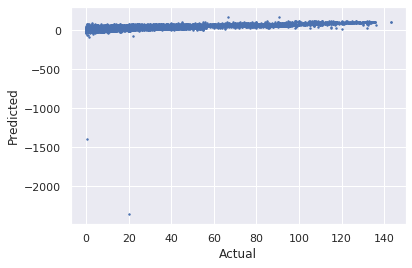

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False))

<Figure size 432x288 with 0 Axes>

In [12]:
# Try also including data on which elements are present

run_linear_regression(X_incl_elements, y, "X_incl_elements", plot=True)

Optimal number of features: 10


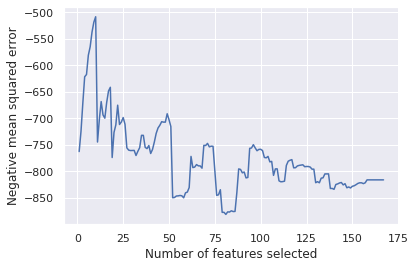

Dropped features: number_of_elements, mean_atomic_mass, wtd_mean_atomic_mass, gmean_atomic_mass, wtd_gmean_atomic_mass, range_atomic_mass, wtd_range_atomic_mass, std_atomic_mass, wtd_std_atomic_mass, mean_fie, wtd_mean_fie, gmean_fie, wtd_gmean_fie, range_fie, wtd_range_fie, std_fie, wtd_std_fie, mean_atomic_radius, wtd_mean_atomic_radius, gmean_atomic_radius, wtd_gmean_atomic_radius, range_atomic_radius, wtd_range_atomic_radius, std_atomic_radius, wtd_std_atomic_radius, mean_Density, wtd_mean_Density, gmean_Density, wtd_gmean_Density, entropy_Density, range_Density, wtd_range_Density, std_Density, wtd_std_Density, mean_ElectronAffinity, wtd_mean_ElectronAffinity, gmean_ElectronAffinity, wtd_gmean_ElectronAffinity, entropy_ElectronAffinity, range_ElectronAffinity, wtd_range_ElectronAffinity, std_ElectronAffinity, wtd_std_ElectronAffinity, mean_FusionHeat, wtd_mean_FusionHeat, gmean_FusionHeat, wtd_gmean_FusionHeat, entropy_FusionHeat, range_FusionHeat, wtd_range_FusionHeat, std_FusionH

In [13]:
# Try to determine the best subset of *all* features using RFE
rfecv, dropped_features = recursive_feature_elim(LinearRegression(), X_incl_elements, y, plot=True)

RMSE: 22.79 (+/- 0.33)
r2: 0.56 (+/- 0.01)
median_absolute_error: 15.24 (+/- 0.53)


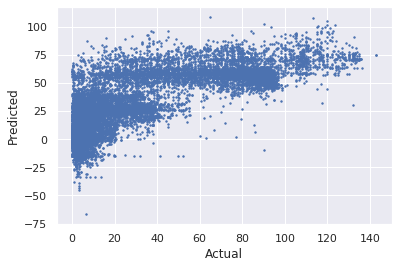

<Figure size 432x288 with 0 Axes>

In [14]:
# Run linear regression without the eliminated features, demonstrating performance is not great with the reduced feature set
X_reduced = X_incl_elements.drop(dropped_features, axis=1)
run_linear_regression(X_reduced, y, "elements_numfeatures", plot=True);

best score with 82 features: -300.8957580504786
best score with 83 features: -295.9018456791041
best score with 84 features: -291.70260530666764
best score with 85 features: -290.05179380566227
best score with 86 features: -289.0690129374287
best score with 87 features: -288.14806170298215
best score with 88 features: -287.4338571640446
best score with 89 features: -286.723003045393
best score with 90 features: -286.11528825026227
best score with 91 features: -285.4399357939844
best score with 92 features: -284.7906652566467
best score with 93 features: -284.2943023527447
best score with 94 features: -283.9970865948704
best score with 95 features: -283.7091340184938
best score with 96 features: -283.4240365261947
best score with 97 features: -283.1956846833075
best score with 98 features: -282.98674485391706
best score with 99 features: -282.7711619705262
best score with 100 features: -282.6173180727939
best score with 101 features: -282.4789176337867
best score with 102 features: -282

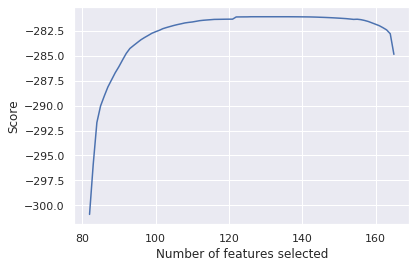

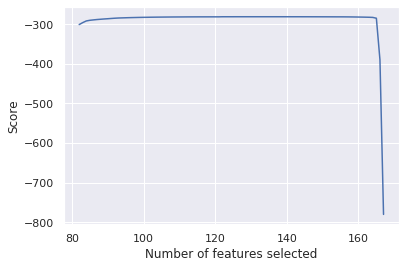

Poor performing last elements: ['Cd', 'Pr']


In [10]:
# Because the above method seemed to perform very poorly, try a more careful approach
# Rather than removing features, add element features to the standard data features gradually, and keep track of the best performing set

all_time_best_X, all_time_best_score, results = iterative_feature_addition("neg_mean_squared_error", 3, LinearRegression(), print_progress=True, plot=False)
print(f'Optimal number of features {len(list(all_time_best_X))}')
plot_iterative_feature_addition_results(results[0:-2])
plot_iterative_feature_addition_results(results)

# Inspect those really bad last elements added
last_two_elements_added = [results[i]['added_feature'] for i in range(-2, 0)]  # it's ['Cd', 'Pr']
print(f'Poor performing last elements: {last_two_elements_added}')

RMSE: 16.76 (+/- 0.42)
r2: 0.76 (+/- 0.02)
median_absolute_error: 9.36 (+/- 0.29)


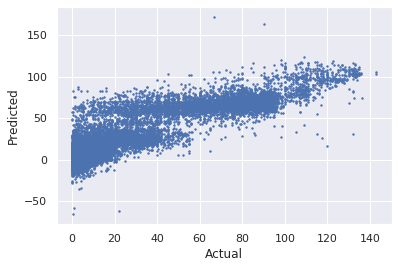

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False))

<Figure size 432x288 with 0 Axes>

In [10]:
run_linear_regression(all_time_best_X, y, "featureadditionresult", plot=True)

degree 1
RMSE: 17.61 (+/- 0.40)
r2: 0.74 (+/- 0.02)
median_absolute_error: 10.19 (+/- 0.29)


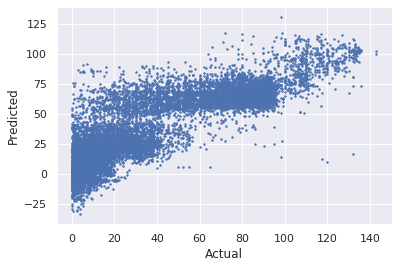

degree 2
RMSE: 16.33 (+/- 0.48)
r2: 0.77 (+/- 0.02)
median_absolute_error: 9.23 (+/- 0.54)


<Figure size 432x288 with 0 Axes>

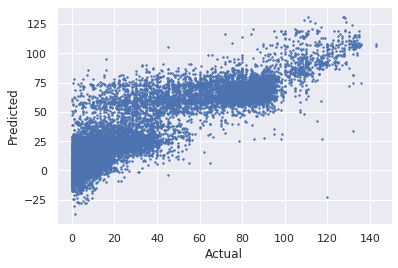

degree 3
RMSE: 15.84 (+/- 0.66)
r2: 0.79 (+/- 0.03)
median_absolute_error: 8.86 (+/- 0.40)


<Figure size 432x288 with 0 Axes>

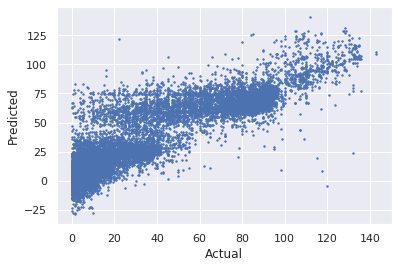

<Figure size 432x288 with 0 Axes>

In [18]:
for i in range(1, 4):
    print("degree " + str(i))
    X_poly_higher_degree = get_poly_no_interaction(X, i)
    run_linear_regression(X_poly_higher_degree, y, f"polynomial_degree_{i}", plot=True)

expanded - degree 1
RMSE: 16.76 (+/- 0.42)
r2: 0.76 (+/- 0.02)
median_absolute_error: 9.36 (+/- 0.29)


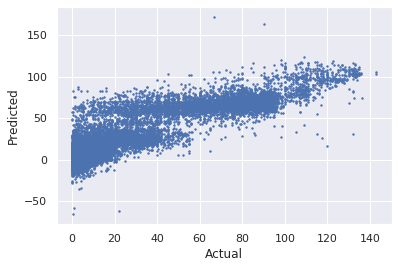

expanded - degree 2
RMSE: 16.33 (+/- 0.95)
r2: 0.77 (+/- 0.04)
median_absolute_error: 8.53 (+/- 0.37)


<Figure size 432x288 with 0 Axes>

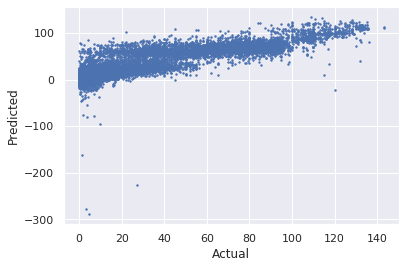

expanded - degree 3
RMSE: 47.78 (+/- 53.84)
r2: -1.58 (+/- 4.77)
median_absolute_error: 8.30 (+/- 0.44)


<Figure size 432x288 with 0 Axes>

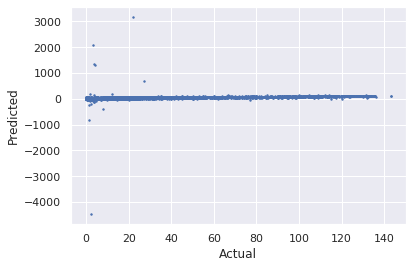

<Figure size 432x288 with 0 Axes>

In [19]:
for i in range(1, 4):
    print("expanded - degree " + str(i))
    X_poly_higher_degree = get_poly_no_interaction(all_time_best_X, i)
    run_linear_regression(X_poly_higher_degree, y, f"polynomial_expanded_degree_{i}", plot=True)

RMSE: 17.61 (+/- 0.41)
r2: 0.74 (+/- 0.02)
median_absolute_error: 10.19 (+/- 0.29)


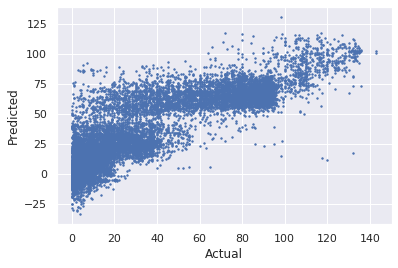

RMSE: 3785299427352892.00 (+/- 6244128916062066.00)
r2: -20423479708339881594251640832.00 (+/- 62972592561750079942802014208.00)
median_absolute_error: 1285917054940801.00 (+/- 2381876313824365.00)


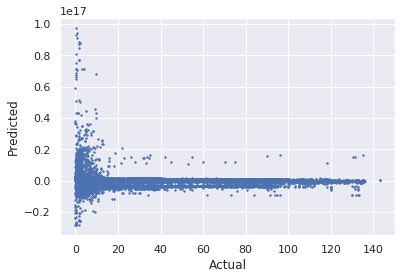

(RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
         gcv_mode=None, normalize=False, scoring=None, store_cv_values=False),
 RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
         gcv_mode=None, normalize=False, scoring=None, store_cv_values=False),
 RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
         gcv_mode=None, normalize=False, scoring=None, store_cv_values=False),
 RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
         gcv_mode=None, normalize=False, scoring=None, store_cv_values=False),
 RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
         gcv_mode=None, normalize=False, scoring=None, store_cv_values=False))

In [24]:
# Try regularising input

run_regression(X, y, "ridge", RidgeCV(), plot=True)

# Ridge does not make much difference with the normal feature set or the full best feature set
X_poly_degree_3 = get_poly_no_interaction(X, 3)

run_regression(X_poly_degree_3, y, "ridge_poly", RidgeCV(), plot=True

Test set performance
RMSE: 15.732250071720493
r2: 0.7330272737746277
Median absolute error: 8.756932808476733


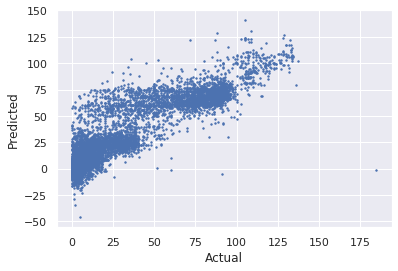

In [31]:
# Finally, run the best model found so far on the test set, for the final evaluation

# Train
model = LinearRegression().fit(X_poly_degree_3, y)

# Test
X_test_poly_3 = get_poly_no_interaction(X_test, 3)
predictions = model.predict(X_test_poly_3)

print('Test set performance')
metrics = {'RMSE': (lambda x, y: math.sqrt(mean_squared_error(x, y))), 'r2': r2_score, 'Median absolute error': median_absolute_error}
for metric, func in metrics.items():
    print(f'{metric}: {func(predictions, y_test)}')

fig, ax = plt.subplots()
ax.scatter(y_test, predictions, s=2)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.savefig("test_set_predictions")
plt.show()